In [2]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

# Extract data from source

In [3]:
# get stock data for Apple
data = yf.download('AAPL', start = '2015-01-01', end = '2021-01-01')

[*********************100%***********************]  1 of 1 completed


# Data for analysis

In [4]:
#get only 'Adj Close','Volume'
stock = data['Adj Close'].copy()

In [5]:
#set higher frequency to business days
stock = stock.asfreq('b')

# Inspecting stock price data 

In [6]:
#check for any nulls
stock.isnull().sum()

54

In [7]:
#fills nulls with backfill method
stock = stock.fillna(method = 'backfill')

In [8]:
#check for any nulls after fill na has been applied
stock.isnull().sum()

0

<AxesSubplot:title={'center':'Apple Stock'}, xlabel='Date'>

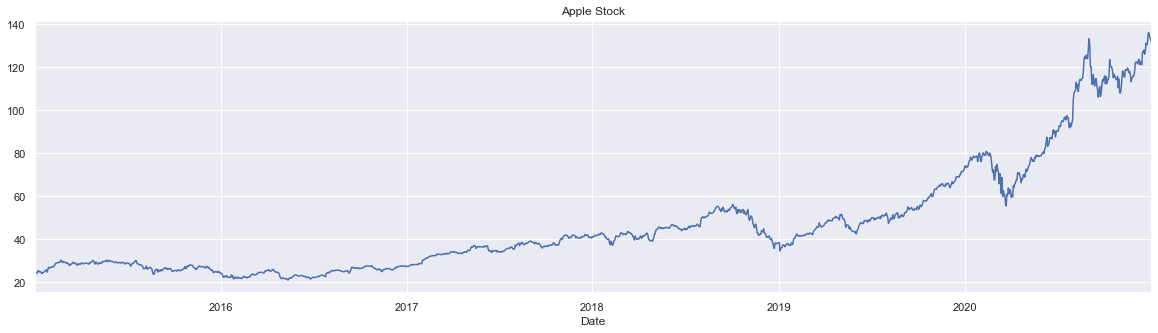

In [10]:
# inspect visually
stock.plot(figsize = (20,5), title = 'Apple Stock')

In [11]:
# descriptive stats
stock.describe()

count   1565.00
mean      46.51
std       25.52
min       21.07
25%       27.59
50%       39.82
75%       52.35
max      136.05
Name: Adj Close, dtype: float64

In [10]:
#QQ Plot - How the data fits a normal distribution
#scipy.stats.probplot(stock, plot = pylab)
#pylab.show()

In [13]:
#Determining weak form stationarity
sts.adfuller(stock)

(2.278813820295892,
 0.9989413292505438,
 24,
 1540,
 {'1%': -3.4346033983723516,
  '5%': -2.863418614437511,
  '10%': -2.5677701454714117},
 4806.218712948001)

# Create MA Model Using % Returns

In [14]:
# Using Returns
stock_r = stock.pct_change(1).mul(100)
stock_r = stock_r.iloc[1:]
stock_r = stock_r.asfreq('b')
stock_r = stock_r.to_frame('returns')

<AxesSubplot:title={'center':'Apple Returns'}, xlabel='Date'>

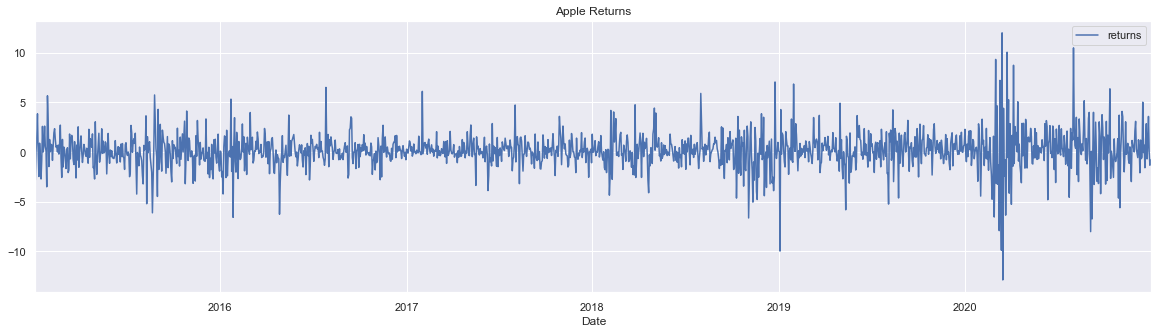

In [15]:
# inspect visually after converted to returns
stock_r.plot(figsize = (20,5), title = 'Apple Returns')

In [14]:
#plot a white noise process to compare
#wn = np.random.normal(loc = stock_r.mean(), scale = stock_r.std(), size = len(stock_r))
#stock_r['wn'] = wn

In [15]:
#plot a white noise process and runs tests to compare
#stock_r.wn.plot(figsize = (20,5), title = 'white noise')
#sts.adfuller(stock_r.wn)
#stock_r.drop(['wn'], axis = 1, inplace = True)

In [16]:
#QQ Plot - How the data fits a normal distribution after transformed to returns
#scipy.stats.probplot(stock_r.returns, plot = pylab)
#pylab.show()

In [16]:
#Determining weak form stationarity for returns
sts.adfuller(stock_r.returns)
#stock_r.plot(figsize = (20,5), title = 'Apple Stock returns')

(-12.070003882878765,
 2.359814843649253e-22,
 8,
 1555,
 {'1%': -3.4345623007753496,
  '5%': -2.8634004754910296,
  '10%': -2.567760486450719},
 6190.025915273094)

In [17]:
# descriptive stats of returns
stock_r.describe()

,returns
count,1564.00
mean,0.12
std,1.83
min,-12.86
25%,-0.59
50%,0.04
75%,0.96
max,11.98


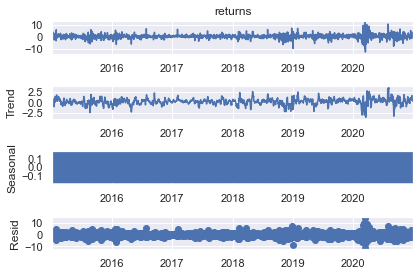

In [18]:
#naive seasonal decomposition --requires at least 2 complete cycles
s_dec_additive = seasonal_decompose(stock_r.returns, model = 'additive')
s_dec_additive.plot()
plt.show()

In [20]:
#naive seasonal decomposition --requires at least 2 complete cycles & not appropiate for 0 or negative values
#s_dec_multiplicative = seasonal_decompose(stock_r, model = 'multiplicative')
#s_dec_additive.plot()
#plt.show()

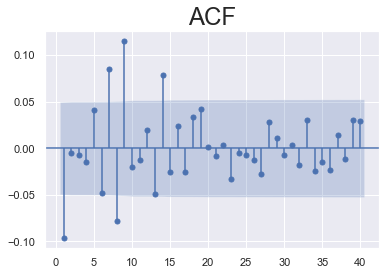

In [19]:
#ACF -- appropiate for MA models
sgt.plot_acf(stock_r, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

In [23]:
# autocorrelation
#autocorrelation_plot(stock_r)

In [20]:
#P & D = 0 and q <> 0 makes ARIMA into MA model
model_ma_1 = ARIMA(stock_r, order = (0,0,1))
model_ma_7 = ARIMA(stock_r, order = (0,0,7))
model_ma_8 = ARIMA(stock_r, order = (0,0,8))
model_ma_9 = ARIMA(stock_r, order = (0,0,9))
model_ma_14 = ARIMA(stock_r, order = (0,0,14))

In [21]:
# fits models
results_ma_1 = model_ma_1.fit()
results_ma_7 = model_ma_7.fit()
results_ma_8 = model_ma_8.fit()
results_ma_9 = model_ma_9.fit()
results_ma_14 = model_ma_14.fit()

In [22]:
#Log Likelihood-ratio test function
from scipy.stats import chi2
def LLR_Test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2 - L1))
    P = chi2.sf(LR, DF).round(3)
    return P

In [53]:
#Selecting best model 
print (' Log Likelihood-ratio & Akaike information criterion')
print(' \n MA lag 1 \tLL =',results_ma_1.llf,' \tAIC =',results_ma_1.aic)
print(' MA lag 7 \tLL =',results_ma_7.llf,'\tAIC =',results_ma_7.aic)
print(' MA lag 8 \tLL =',results_ma_8.llf,'\tAIC =',results_ma_8.aic)
print(' MA lag 9 \tLL =',results_ma_9.llf,'\tAIC =',results_ma_9.aic)
print(' MA lag 14 \tLL =',results_ma_14.llf,'\tAIC =',results_ma_14.aic)
print ('\n Statistical significance of delta in Log Likelihood-ratio')
print('\n MA 1 v MA 7 \tLLR Test P-Value:' + str(LLR_Test(model_ma_1,model_ma_7, DF = 6)))
print(' MA 7 v MA 8 \tLLR Test P-Value:' + str(LLR_Test(model_ma_7,model_ma_8)))
print(' MA 8 v MA 9 \tLLR Test P-Value:' + str(LLR_Test(model_ma_8,model_ma_9)))
print(' MA 9 v MA 14 \tLLR Test P-Value:' + str(LLR_Test(model_ma_9,model_ma_14, DF = 5)))

 Log Likelihood-ratio & Akaike information criterion
 
 MA lag 1 	LL = -3159.9744575534305  	AIC = 6325.948915106861
 MA lag 7 	LL = -3153.6652233655855 	AIC = 6325.330446731171
 MA lag 8 	LL = -3151.8071890655306 	AIC = 6323.614378131061
 MA lag 9 	LL = -3144.1811178608264 	AIC = 6310.362235721653
 MA lag 14 	LL = -3136.522293418371 	AIC = 6305.044586836742

 Statistical significance of delta in Log Likelihood-ratio

 MA 1 v MA 7 	LLR Test P-Value:0.05
 MA 7 v MA 8 	LLR Test P-Value:0.054
 MA 8 v MA 9 	LLR Test P-Value:0.0
 MA 9 v MA 14 	LLR Test P-Value:0.009


In [24]:
#Summary of the best fitting model
print(results_ma_14.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                ARIMA(0, 0, 14)   Log Likelihood               -3136.522
Date:                Fri, 05 Nov 2021   AIC                           6305.045
Time:                        12:04:45   BIC                           6390.725
Sample:                    01-05-2015   HQIC                          6336.897
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1242      0.050      2.475      0.013       0.026       0.223
ma.L1         -0.0759      0.019     -4.046      0.000      -0.113      -0.039
ma.L2         -0.0279      0.017     -1.679      0.0

# Residuals of Returns

In [54]:
#Analyzing residuals 
mod_res = model_ma_14.fit().resid

In [40]:
#Desc stats of residuals--stats of interest are mean and std
mod_res.describe()

count   1564.00
mean      -0.00
std        1.80
min      -10.69
25%       -0.76
50%       -0.04
75%        0.89
max       10.19
dtype: float64

In [41]:
#Determining weak form stationarity for residuals
sts.adfuller(mod_res)

(-39.61812724165066,
 0.0,
 0,
 1563,
 {'1%': -3.4345407051300514,
  '5%': -2.863390943879109,
  '10%': -2.567755410866859},
 6168.081937478586)

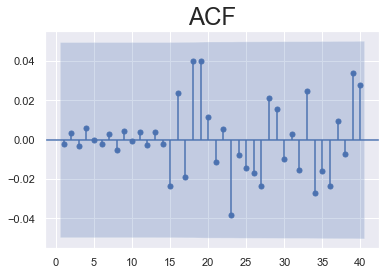

In [42]:
#ACF of residuals for returns
sgt.plot_acf(mod_res, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

<AxesSubplot:xlabel='Date'>

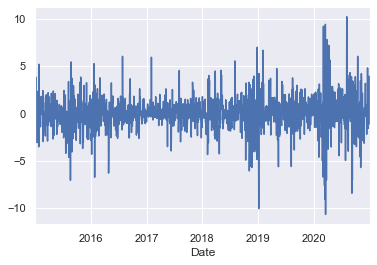

In [43]:
mod_res.plot()

# Create MA Models Using Normalized % Returns

In [30]:
#Create benchmark
benchmark = stock_r.iloc[0]

In [31]:
#normalize
stock_rn = stock_r.div(benchmark).mul(100)

In [32]:
# descriptive stats of normalized returns
stock_rn.describe()

,returns
count,1564.00
mean,-4.40
std,65.11
min,-425.28
25%,-34.03
50%,-1.50
75%,21.03
max,456.65


In [33]:
#check for stationarity
sts.adfuller(stock_rn)

(-12.070003882878742,
 2.359814843649473e-22,
 8,
 1555,
 {'1%': -3.4345623007753496,
  '5%': -2.8634004754910296,
  '10%': -2.567760486450719},
 17176.745407249386)

<AxesSubplot:title={'center':'Normalized Apple Returns'}, xlabel='Date'>

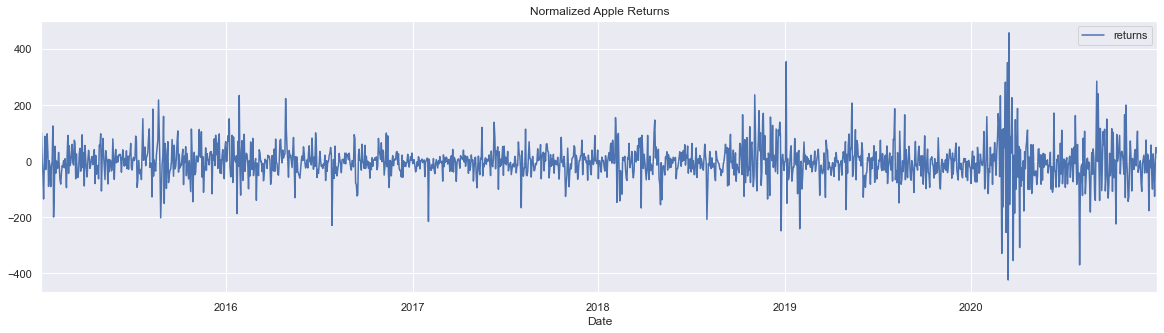

In [34]:
# inspect visually after converted to retunrs
stock_rn.plot(figsize = (20,5), title = 'Normalized Apple Returns')

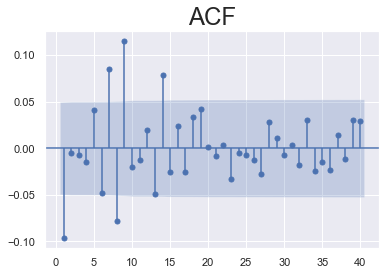

In [44]:
#ACF normalized returns
sgt.plot_acf(stock_rn, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

In [37]:
#P & D = 0 and q <> 0 makes ARIMA into MA model
model_man_1 = ARIMA(stock_rn, order = (0,0,1))
model_man_7 = ARIMA(stock_rn, order = (0,0,7))
model_man_8 = ARIMA(stock_rn, order = (0,0,8))
model_man_9 = ARIMA(stock_rn, order = (0,0,9))
model_man_14 = ARIMA(stock_rn, order = (0,0,14))

In [38]:
# fits models
results_man_1 = model_man_1.fit()
results_man_7 = model_man_7.fit()
results_man_8 = model_man_8.fit()
results_man_9 = model_man_9.fit()
results_man_14 = model_man_14.fit()

In [45]:
#Selecting best model 
print (' Log Likelihood-ratio & Akaike information criterion')
print(' \n MA lag 1 \tLL =',results_man_1.llf,' \tAIC =',results_man_1.aic)
print(' MA lag 7 \tLL =',results_man_7.llf,'\tAIC =',results_man_7.aic)
print(' MA lag 8 \tLL =',results_man_8.llf,' \tAIC =',results_man_8.aic)
print(' MA lag 9 \tLL =',results_man_9.llf,'\tAIC =',results_man_9.aic)
print(' MA lag 14 \tLL =',results_man_14.llf,'\tAIC =',results_man_14.aic)
print ('\n Statistical significance of delta in Log Likelihood-ratio')
print('\n MA 1 v MA 7 \tLLR Test P-Value:' + str(LLR_Test(model_man_1,model_man_7, DF = 6)))
print(' MA 7 v MA 8 \tLLR Test P-Value:' + str(LLR_Test(model_man_7,model_man_8)))
print(' MA 8 v MA 9 \tLLR Test P-Value:' + str(LLR_Test(model_man_8,model_man_9)))
print(' MA 9 v MA 14 \tLLR Test P-Value:' + str(LLR_Test(model_man_9,model_man_14, DF = 5)))

 Log Likelihood-ratio & Akaike information criterion
 
 MA lag 1 	LL = -8742.572072451785  	AIC = 17491.14414490357
 MA lag 7 	LL = -8736.260976644182 	AIC = 17490.521953288364
 MA lag 8 	LL = -8734.403031108917  	AIC = 17488.806062217835
 MA lag 9 	LL = -8726.779030853075 	AIC = 17475.55806170615
 MA lag 14 	LL = -8719.123098218126 	AIC = 17470.246196436252

 Statistical significance of delta in Log Likelihood-ratio

 MA 1 v MA 7 	LLR Test P-Value:0.049
 MA 7 v MA 8 	LLR Test P-Value:0.054
 MA 8 v MA 9 	LLR Test P-Value:0.0
 MA 9 v MA 14 	LLR Test P-Value:0.009


In [47]:
#Summary of the best fitting model
print(results_man_14.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                ARIMA(0, 0, 14)   Log Likelihood               -8719.123
Date:                Fri, 05 Nov 2021   AIC                          17470.246
Time:                        13:08:08   BIC                          17555.926
Sample:                    01-05-2015   HQIC                         17502.098
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3971      1.788     -2.459      0.014      -7.901      -0.893
ma.L1         -0.0759      0.019     -4.031      0.000      -0.113      -0.039
ma.L2         -0.0279      0.017     -1.673      0.0

# Residuals of Normalized Returns

In [48]:
#Analyzing residuals 
mod_resn = model_man_14.fit().resid

In [49]:
#Desc stats of residuals--stats of interest are mean and std
mod_res.describe()

count   1564.00
mean      -0.00
std        1.80
min      -10.69
25%       -0.76
50%       -0.04
75%        0.89
max       10.19
dtype: float64

In [50]:
#Determining weak form stationarity for residuals
sts.adfuller(mod_resn)

(-39.6185759190718,
 0.0,
 0,
 1563,
 {'1%': -3.4345407051300514,
  '5%': -2.863390943879109,
  '10%': -2.567755410866859},
 17154.801583597884)

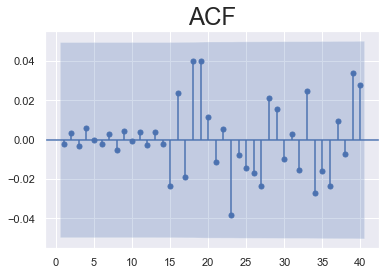

In [51]:
#ACF of residuals for returns
sgt.plot_acf(mod_resn, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

<AxesSubplot:xlabel='Date'>

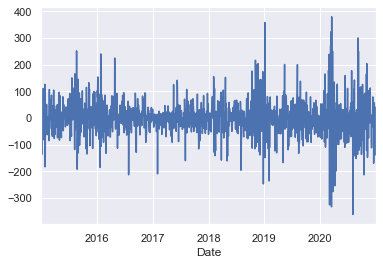

In [52]:
mod_resn.plot()